In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

import pymc as pm
import arviz as az
import stan
import aesara.tensor as at
import nest_asyncio

from scipy.special import ndtri
from scipy.stats import norm, lognorm
from scipy.optimize import minimize

from sklearn.metrics import roc_auc_score

import time

from utils import stan_wrapper, stan_visualize_out, stan_predict, pymc_wrapper, pymc_predict, MLS_wrapper, minimize_predict

NameError: name 'INIT_VALUES' is not defined

In [ ]:
FACTOR = 1/100
beta = 0.88

fname = 'results_raw.pickle'
# Create a writer object
file = open(fname, 'rb')
# dump information
results_decision = pickle.load(file)
# close file
file.close()

fname = 'results_raw_50.pickle'
# Create a writer object
file = open(fname, 'rb')
# dump information
results_decision_50 = pickle.load(file)
# close file
file.close()

fname = 'results_raw_25.pickle'
# Create a writer object
file = open(fname, 'rb')
# dump information
results_decision_25 = pickle.load(file)
# close file
file.close()

df_25 = pd.concat(results_decision_25, names=['subject'])
df_50 = pd.concat(results_decision_50, names=['subject'])

results_decision_50.keys()
df = results_decision_50['11112']

mu_theta, mu_Lambda, mu_tau, mu_alpha, mu_gamma = -1.32617141, 0.41613512, -1.37750916, -0.24550931, -0.13804112
sig_theta, sig_Lambda, sig_tau, sig_alpha, sig_gamma = 0.19484903, 0.71492692,  0.17975801, 0.08284753, 0.67868274
sig_error = 1.9222773
x0 = np.array([mu_theta, sig_theta, mu_Lambda, sig_Lambda, mu_tau, sig_tau, mu_alpha, sig_alpha, mu_gamma, sig_gamma, sig_error])

distro_estimates = {'mu':{'theta': x0[0], 'Lambda': x0[2], 'tau': x0[4], 'alpha': x0[6], 'gamma': x0[8]},
                         'sigma':{'theta': x0[1], 'Lambda': x0[3], 'tau': x0[5], 'alpha': x0[7],  'gamma': x0[9], 'error':x0[10]}}
distro_estimates_export = pd.DataFrame(distro_estimates)
distro_estimates_export['exp(mu)'] = np.exp(distro_estimates_export['mu'])
distro_estimates_export.to_csv('distro_estimates_errors_tau_repeat.csv')
distro_estimates_export


THETA_INIT = 0.42
LAMBDA_INIT = 1.6
TAU_INIT = .28
ALPHA_INIT = .9
GAMMA_INIT = .7
ERROR_INIT = 0


INIT_VALUES = np.array([THETA_INIT, LAMBDA_INIT, TAU_INIT, ALPHA_INIT, GAMMA_INIT, ERROR_INIT])

THETA_INIT, LAMBDA_INIT, TAU_INIT, ALPHA_INIT, GAMMA_INIT, ERROR_INIT = INIT_VALUES

NameError: name 'pickle' is not defined

In [4]:
results_decision_50

NameError: name 'results_decision_50' is not defined

In [4]:
def stan_wrapper(df, x0, INIT_VALUES=INIT_VALUES, FACTOR=1, beta = 0.88):
    """
    Wrapper function to prepare data for Stan model.
    """
    
    
    # Ensure the DataFrame has the required columns
    required_columns = ['gain', 'loss', 'prob_win', 'prob_loss', 'prob_ambi', 'invest']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"DataFrame must contain column: {col}")



    # Convert 'invest' to binary (0 or 1)
    df['invest'] = df['invest'].apply(lambda x: 1 if x > 0 else 0)

    # # Add beta to stan_data, as it is used in the Stan model
    # beta = 0.88
    
    mu_theta, sig_theta, mu_Lambda, sig_Lambda, mu_tau, sig_tau, mu_alpha, sig_alpha, mu_gamma, sig_gamma, sig_error = x0

    # Prepare stan_data dictionary
    stan_data = {
        'N': len(df),
        'gain': df['gain'].values* FACTOR,
        'loss': df['loss'].values* FACTOR,
        'prob_win': df['prob_win'].values,
        'prob_loss': df['prob_loss'].values,
        'prob_ambi': df['prob_ambi'].values,
        'invest': df['invest'].astype(int).values,
        'mu_theta': mu_theta,
        'sigma_theta': sig_theta,
        'mu_Lambda': mu_Lambda,
        'sigma_Lambda': sig_Lambda,
        'mu_tau': mu_tau,
        'sigma_tau': sig_tau,
        'mu_alpha': mu_alpha,
        'sigma_alpha': sig_alpha,
        'mu_gamma': mu_gamma,
        'sigma_gamma': sig_gamma,
        'sigma_error': sig_error,
        'beta': beta
    }

    nest_asyncio.apply()


    # Convert init_values to a dictionary for Stan
    init_values = {
        'theta': INIT_VALUES[0],
        'Lambda': INIT_VALUES[1],
        'tau': INIT_VALUES[2],
        'alpha': INIT_VALUES[3],
        'gamma': INIT_VALUES[4],
        'error': INIT_VALUES[5]
    }

    # Update Stan model code to accept beta as data
    stan_model_code = """
    data {
        int<lower=0> N; // number of observations
        vector[N] gain; // gains
        vector[N] loss; // losses
        vector[N] prob_win; // probability of winning
        vector[N] prob_loss; // probability of losing
        vector[N] prob_ambi; // probability of ambiguity
        array[N] int<lower=0, upper=1> invest; // observed investment decisions

        real mu_theta;
        real sigma_theta;
        real mu_Lambda;
        real sigma_Lambda;
        real mu_tau;
        real sigma_tau;
        real mu_alpha;
        real sigma_alpha;
        real mu_gamma;
        real sigma_gamma;
        real sigma_error;
        real beta; // <-- added beta as data
    }

    parameters {
        real<lower=0> theta; // parameter theta
        real<lower=0> Lambda; // parameter Lambda
        real<lower=0> tau; // parameter tau
        real<lower=0> alpha; // parameter alpha
        real<lower=0> gamma; // parameter gamma
        real error; // error term
    }

    model {
        // Priors
        theta ~ lognormal(mu_theta, sigma_theta);
        Lambda ~ lognormal(mu_Lambda, sigma_Lambda);
        tau ~ lognormal(mu_tau, sigma_tau);
        alpha ~ lognormal(mu_alpha, sigma_alpha);
        gamma ~ lognormal(mu_gamma, sigma_gamma);
        error ~ normal(0, sigma_error);

        // Likelihood
        for (n in 1:N) {
            real utility = (gain[n] >= 0 ? pow(gain[n], alpha) : -Lambda * pow(-gain[n], beta)) * 
                        pow(prob_win[n] + prob_ambi[n] * theta, gamma) +
                        (loss[n] >= 0 ? pow(loss[n], alpha) : -Lambda * pow(-loss[n], beta)) * 
                        pow(prob_loss[n] + prob_ambi[n] * (1 - theta), gamma);
            
            invest[n] ~ bernoulli_logit(tau * (utility - error));
        }
    }
    """


    # Compile the Stan model (synchronously in Jupyter)
    posterior = stan.build(stan_model_code, data=stan_data)

    # Fit the model
    stan_fit = posterior.sample(num_chains=4, num_samples=1000, init=[init_values]*4)
    
    return stan_fit


def stan_visualize_out(stan_fit, figure_flag=True):
	"""
	Function to visualize the output of the Stan model.
	"""
	# Convert the fit to a DataFrame for easier plotting
	samples = stan_fit.to_frame()

	if figure_flag:
		# Plot posterior distributions for all parameters
		fig, axes = plt.subplots(len(samples.columns), 1, figsize=(8, 2 * len(samples.columns)), constrained_layout=True)
		if len(samples.columns) == 1:
			axes = [axes]
		for ax, col in zip(axes, samples.columns):
			ax.hist(samples[col], bins=30, density=True, alpha=0.7)
			ax.set_title(f'Posterior of {col}')
		plt.show()

	print(stan_fit.to_frame().describe()[['theta', 'Lambda', 'tau', 'alpha', 'gamma', 'error']].T)


def stan_predict(stan_fit, df, FACTOR=1):
    """
    Function to predict using the Stan model.
    """
    # Extract the mean of the posterior samples for each parameter
    theta = stan_fit.to_frame()['theta'].mean()
    Lambda = stan_fit.to_frame()['Lambda'].mean()
    alpha = stan_fit.to_frame()['alpha'].mean()
    tau = stan_fit.to_frame()['tau'].mean()
    beta = 0.88  # already defined as 0.88
    gamma = stan_fit.to_frame()['gamma'].mean()
    error = stan_fit.to_frame()['error'].mean()

    predictions = []

    for _, row in df.iterrows():
        gain = row['gain'] * FACTOR
        loss = row['loss'] * FACTOR 
        prob_win = row['prob_win']
        prob_loss = row['prob_loss']
        prob_ambi = row['prob_ambi']

        # Calculate subjective probabilities and values using numpy
        def np_calc_subj_values(x, Lambda, alpha, beta):
            return x**alpha if x >= 0 else -Lambda * ((-x)**beta)

        def np_calc_eta(green, red, theta, prob_ambi):
            return green + prob_ambi * theta

        def np_calc_subj_prob(prob, gamma):
            return prob**gamma / (prob**gamma + (1 - prob)**gamma)**(1/gamma)

        prob_g = np.clip(np_calc_eta(prob_win, prob_loss, theta, prob_ambi), 0, 1)
        prob_l = np.clip(np_calc_eta(prob_loss, prob_win, 1-theta, prob_ambi), 0, 1)
        subj_gain = np_calc_subj_values(gain, Lambda, alpha, beta)
        subj_loss = np_calc_subj_values(loss, Lambda, alpha, beta)
        subj_prob_g = np_calc_subj_prob(prob_g, gamma)
        subj_prob_l = np_calc_subj_prob(prob_l, gamma)
        utility = subj_gain * subj_prob_g + subj_loss * subj_prob_l

        # Probability to invest
        p_invest = 1 / (1 + np.exp(-tau * (utility - error)))
        
        # Predict invest = 1 if p_invest > 0.5, else 0
        invest_pred = int(p_invest > 0.5)
        predictions.append(invest_pred)

    return predictions




In [5]:

start_time  = time.time()
stan_fit    = stan_wrapper(df, x0, INIT_VALUES= INIT_VALUES,     FACTOR = FACTOR, beta=beta)
stan_time   = time.time() - start_time

if 0:
    stan_visualize_out(stan_fit, figure_flag=True)



Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   4% (300/8000)
Sampling:   6% (500/8000)
Sampling:   9% (700/8000)
Sampling:  19% (1500/8000)
Sampling:  41% (3300/8000)
Sampling:  64% (5100/8000)
Sampling:  86% (6900/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messa

/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_1596/3616685394.py:45: RuntimeWarning: invalid value encountered in power
  return at.switch(x >= 0, x**alpha, -Lambda * (-x)**beta)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, Lambda, tau, alpha, gamma, error]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 49 seconds.


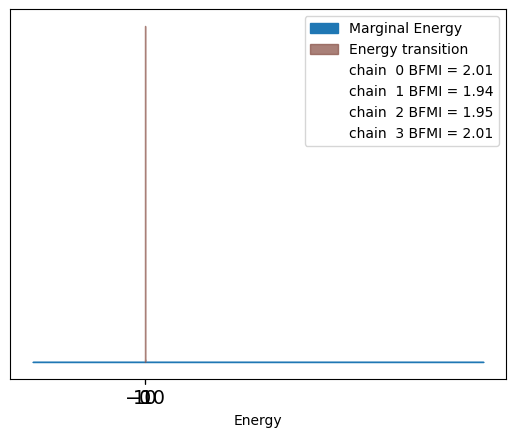

X axis values (energy):
[1878115.45177047 1878113.29902963 1878112.32616404 ...    4450.86409201
    4450.5723653     4448.86846976]


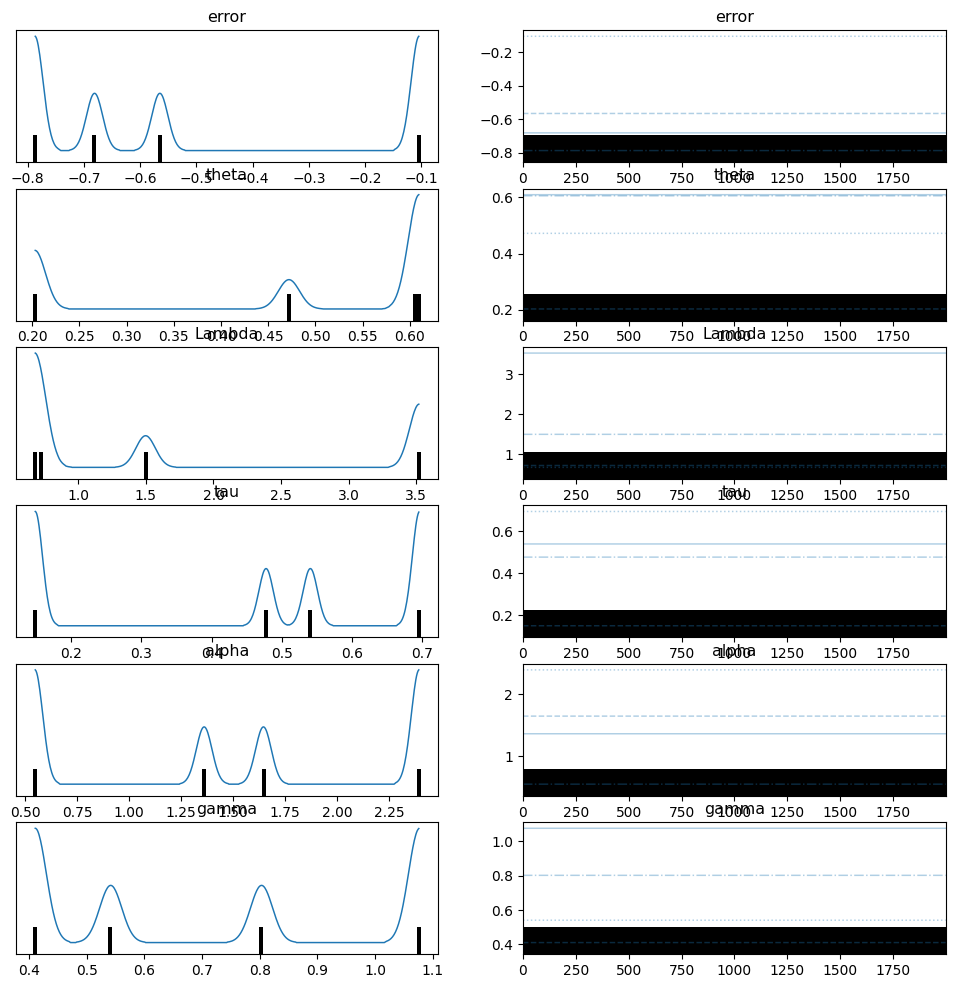

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta   0.473  0.165   0.203    0.610      0.083    0.041       4.0       4.0   
Lambda  1.606  1.154   0.678    3.523      0.576    0.301       4.0       4.0   
tau     0.465  0.199   0.148    0.695      0.100    0.051       4.0       4.0   
alpha   1.487  0.662   0.546    2.395      0.330    0.158       4.0       4.0   
gamma   0.707  0.256   0.410    1.077      0.128    0.049       4.0       4.0   
error  -0.534  0.261  -0.787   -0.104      0.130    0.068       4.0       4.0   

               r_hat  
theta   5.341631e+15  
Lambda  5.877474e+15  
tau     5.341631e+15  
alpha   5.341631e+15  
gamma   5.877474e+15  
error   5.877474e+15  
PyMC fitting time: 59.98 seconds


In [6]:



def pymc_wrapper(df, distro_estimates, INIT_VALUES, FACTOR=1, beta=0.88, energy_plot_flag=True, distri_plot_flag=True):
    """
    Wrapper function for PyMC model fitting.
    """
    
    
    gain      = df['gain'].values * FACTOR
    loss      = df['loss'].values * FACTOR
    prob_win  = df['prob_win'].values
    prob_loss = df['prob_loss'].values
    prob_ambi = df['prob_ambi'].values
    invest    = df['invest'].values.astype(int)

    THETA_INIT, LAMBDA_INIT, TAU_INIT, ALPHA_INIT, GAMMA_INIT, ERROR_INIT = INIT_VALUES
    initvals = {
        'theta': THETA_INIT,
        'Lambda': LAMBDA_INIT,
        'tau': TAU_INIT,
        'alpha': ALPHA_INIT,
        'gamma': GAMMA_INIT,
        'error': ERROR_INIT
    }

    def lognormal_pdf(value, mu, sigma):
        ''' Function to calculate the lognormal density'''
        shape  = sigma
        loc    = 0
        scale  = np.exp(mu)
        return lognorm.pdf(value, shape, loc, scale)

    def normal_pdf(value, mu, sigma):
        ''' Function to calculate the lognormal density'''
        loc    = 0
        scale  = sigma
        return norm.pdf(value, loc, scale)

    def calc_eta(green, red, theta, prob_ambi):
        # prob_ambi is always provided in your data
        return green + prob_ambi * theta

    def calc_subj_prob(prob, gamma):
        return prob**gamma / (prob**gamma + (1 - prob)**gamma)**(1/gamma)

    def calc_subj_values(x, Lambda, alpha, beta):
        return at.switch(x >= 0, x**alpha, -Lambda * (-x)**beta)

    def calc_pt_utility(gain, loss, prob_win, prob_loss, theta, Lambda, alpha, beta, gamma, prob_ambi):
        prob_g = at.clip(calc_eta(prob_win, prob_loss, theta, prob_ambi), 0, 1)
        prob_l = at.clip(calc_eta(prob_loss, prob_win, 1-theta, prob_ambi), 0, 1)
        u = (
            calc_subj_values(gain, Lambda, alpha, beta) * calc_subj_prob(prob_g, gamma) +
            calc_subj_values(loss, Lambda, alpha, beta) * calc_subj_prob(prob_l, gamma)
        )
        return u

    def calc_prob_invest(utility, tau, error):
        return 1 / (1 + at.exp(-tau * (utility - error)))
    
    
    with pm.Model() as model:
        # Priors
        theta  = pm.Lognormal('theta', mu=distro_estimates['mu']['theta'], sigma=distro_estimates['sigma']['theta'])
        Lambda = pm.Lognormal('Lambda', mu=distro_estimates['mu']['Lambda'], sigma=distro_estimates['sigma']['Lambda'])
        tau    = pm.Lognormal('tau', mu=distro_estimates['mu']['tau'], sigma=distro_estimates['sigma']['tau'])
        alpha  = pm.Lognormal('alpha', mu=distro_estimates['mu']['alpha'], sigma=distro_estimates['sigma']['alpha'])
        gamma  = pm.Lognormal('gamma', mu=distro_estimates['mu']['gamma'], sigma=distro_estimates['sigma']['gamma'])
        error  = pm.Normal('error', mu=0, sigma=distro_estimates['sigma']['error'])

        # Utility and probability
        utility = calc_pt_utility(
            gain=gain,
            loss=loss,
            prob_win=prob_win,
            prob_loss=prob_loss,
            theta=theta,
            Lambda=Lambda,
            alpha=alpha,
            beta=beta,
            gamma=gamma,
            prob_ambi=prob_ambi
        )
        p = calc_prob_invest(utility, tau, error)

        # Likelihood
        invest_obs = pm.Bernoulli('invest_obs', p=p, observed=invest)
        
        trace = pm.sample(2000, tune=2000, target_accept=0.9, chains=4, initvals=initvals, return_inferencedata=True)

        
        # # Define batch_size and max_draws for sampling
        # batch_size = 1000
        # max_draws = 5000
        # draws = 0
        # converged = False
        # trace = None

        # while draws < max_draws and not converged:
        #     new_trace = pm.sample(
        #         draws=batch_size,
        #         tune=0 if trace is not None else batch_size,
        #         target_accept=0.9,
        #         chains=4,
        #         initvals=initvals if trace is None else None,
        #         return_inferencedata=True,
        #         progressbar=True
        #     )
        #     # Concatenate traces
        #     if trace is None:
        #         trace = new_trace
        #     trace = az.concat(trace, new_trace, dim="draw")

        #     draws += batch_size

        #     # Check convergence using r_hat
        #     summary = az.summary(trace, var_names=["theta", "Lambda", "tau", "alpha", "gamma", "error"])
        #     r_hat = summary['r_hat'].max()
        #     print(f"Draws: {draws}, max r_hat: {r_hat:.3f}")
        #     if r_hat < 1.01:
        #         converged = True

        # if not converged:
        #     print("Warning: Maximum draws reached before convergence.")

        #     # Check convergence using r_hat
        #     summary = az.summary(trace, var_names=["theta", "Lambda", "tau", "alpha", "gamma", "error"])
        #     r_hat = summary['r_hat'].max()
        #     print(f"Draws: {draws}, max r_hat: {r_hat:.3f}")
        #     if r_hat < 1.01:
        #         converged = True

        # if not converged:
        #     print("Warning: Maximum draws reached before convergence.")


        if energy_plot_flag:
            az.plot_energy(trace)
            plt.xlabel("Energy")
            energy = trace.sample_stats["energy"].values.flatten()
            plt.xticks(np.round(np.linspace(-10, 10, num=3), 2))
            plt.show()
            print("X axis values (energy):")
            print(energy)    
            
        if distri_plot_flag:
            az.plot_trace(trace, combined=True)
            plt.show()
            
        # Extract posterior means for each parameter from the trace
        summary = az.summary(trace, var_names=["theta", "Lambda", "tau", "alpha", "gamma", "error"])
        print(summary)
    
    return trace



def pymc_predict(trace, df, FACTOR=1, beta=0.88):
    """
    Function to predict using the PyMC model trace.
    """
    # Extract the mean of the posterior samples for each parameter
    theta   = trace.posterior['theta'].mean().item()
    Lambda  = trace.posterior['Lambda'].mean().item()
    alpha   = trace.posterior['alpha'].mean().item()
    tau     = trace.posterior['tau'].mean().item()
    gamma   = trace.posterior['gamma'].mean().item()
    error   = trace.posterior['error'].mean().item()

    predictions = []

    for _, row in df.iterrows():
        gain = row['gain'] * FACTOR
        loss = row['loss'] * FACTOR 
        prob_win = row['prob_win']
        prob_loss = row['prob_loss']
        prob_ambi = row['prob_ambi']

        def np_calc_subj_values(x, Lambda, alpha, beta):
            return x**alpha if x >= 0 else -Lambda * ((-x)**beta)

        def np_calc_eta(green, red, theta, prob_ambi):
            return green + prob_ambi * theta

        def np_calc_subj_prob(prob, gamma):
            return prob**gamma / (prob**gamma + (1 - prob)**gamma)**(1/gamma)

        prob_g = np.clip(np_calc_eta(prob_win, prob_loss, theta, prob_ambi), 0, 1)
        prob_l = np.clip(np_calc_eta(prob_loss, prob_win, 1-theta, prob_ambi), 0, 1)
        subj_gain = np_calc_subj_values(gain, Lambda, alpha, beta)
        subj_loss = np_calc_subj_values(loss, Lambda, alpha, beta)
        subj_prob_g = np_calc_subj_prob(prob_g, gamma)
        subj_prob_l = np_calc_subj_prob(prob_l, gamma)
        utility = subj_gain * subj_prob_g + subj_loss * subj_prob_l

        # Probability to invest
        p_invest = 1 / (1 + np.exp(-tau * (utility - error)))
        
        # Predict invest = 1 if p_invest > 0.5, else 0
        invest_pred = int(p_invest > 0.5)
        predictions.append(invest_pred)

    return predictions


# You can now analyze the trace object for posterior inference
start_time_pymc = time.time()

trace = pymc_wrapper(df, distro_estimates, INIT_VALUES, FACTOR=1, beta=0.88, energy_plot_flag=True, distri_plot_flag=True)

pymc_time = time.time() - start_time_pymc
print(f"PyMC fitting time: {pymc_time:.2f} seconds")

In [7]:


def MLS_wrapper(df, x0, distro_estimates):
    
    # Calculate eta (perceived probability of a successful investment due ambiguity).
    def calc_eta(green, red, theta, prob_ambi=None):
        ''' Calculates the eta given prob_win, prob_loss, and ambiguity. theta is estimated.'''
        if prob_ambi==None:
            return round(green + (1-green-red)*theta,3)
        else:
            # if prob_ambi+red+green!=1:
            #     print(f'Probabilities do not add up to 0: {prob_ambi+red+green}')
            return round(green + prob_ambi*theta,3)

    # Calculate subject probability (using the perceived eta).
    def calc_subj_prob(prob, gamma=1):
        ''' Converts the preceived probabilities to subjective probability. gamma is estimated.'''
        return prob**gamma/(prob**gamma + (1-prob)**gamma)**(1/gamma)

    # Calculating the subjective value of losses and gains. Lambda estimated
    def calc_subj_values(x, Lambda, alpha, beta):
        ''' Calculates the subjective value of gains and losses, given an alpha parameter. Lambda estimate. Alpha could be estimated but used as constant=0.9.'''
        if x >= 0:
            return x**alpha
        else:
            return -Lambda*(-x)**beta

    # Calculating prospect utility.
    def calc_pt_utility(gain, loss, prob_win, prob_loss, theta, Lambda, alpha, beta, gamma=1, prob_ambi=None):
        ''' Calculates the prospect theory utility of investing. Losses are negative numbers and we just add all the outcomes*probabilities.'''
        # print(max(0,calc_eta(prob_win, prob_loss, theta, prob_ambi)))
        # print(min(max(0,calc_eta(prob_win, prob_loss, theta, prob_ambi)),1))
        prob_g = calc_eta(prob_win, prob_loss, theta, prob_ambi).clip(0,1)
        prob_l = calc_eta(prob_loss, prob_win, 1-theta, prob_ambi).clip(0,1)
        pt_u   = calc_subj_values(gain, Lambda, alpha, beta) * calc_subj_prob(prob_g, gamma=gamma) + calc_subj_values(loss, Lambda, alpha, beta) * calc_subj_prob(prob_l, gamma=gamma)
        return pt_u

    # Calculating the probability to invest.
    def calc_prob_invest_data(invest,utility,tau,error):
        yy = 2*invest-1
        return (1)/(1+np.exp(-tau*(utility-error)*yy))

    # classify whether somebody invests or not.
    def likelihood_data(invest,gain, loss, prob_win, prob_loss, theta, Lambda, tau, alpha, beta, gamma,error):
        ''' Function to determine if someone would invest in the gamble given theta, gamma, lambda, and tau.'''
        utility = calc_pt_utility(gain, loss, prob_win, prob_loss, theta, Lambda, alpha, beta, gamma)
        probability = calc_prob_invest_data(invest,utility,tau, error)
        return probability
    
    
    def lognormal_pdf(value, mu, sigma):
        ''' Function to calculate the lognormal density'''
        shape  = sigma
        loc    = 0
        scale  = np.exp(mu)
        return lognorm.pdf(value, shape, loc, scale)

    def normal_pdf(value, mu, sigma):
        ''' Function to calculate the lognormal density'''
        loc    = 0
        scale  = sigma
        return norm.pdf(value, loc, scale)



    def log_likelihood_subject(param_list, sub_df, distro_estimates):
        ''' This is the functions that is going to minimized'''
        # initialize and collect
        FACTOR = 1/100
        df = sub_df.copy(True)
        parameters = {}
        lognormal_values = {}
        
        # PARAMETERS
        for idx, param in enumerate(['theta', 'Lambda', 'tau', 'alpha', 'gamma', 'error']):
            parameters[param] = param_list[idx]
        # parameters['tau'] = .28    
        parameters['beta'] = .88
        
        # calculate the likelihood of the data given the parameters
        df['ll_data'] = df.apply(lambda x: likelihood_data(x['invest'], 
                                                        x['gain']*FACTOR, 
                                                        x['loss']*FACTOR,
                                                        x['prob_win'], 
                                                        x['prob_loss'],
                                                            parameters['theta'], 
                                                            parameters['Lambda'], 
                                                            parameters['tau'], 
                                                            parameters['alpha'], 
                                                            parameters['beta'], 
                                                            parameters['gamma'],
                                                            parameters['error']), axis=1)

        # calculate the lognormal distribution weights
        for par in ['theta', 'Lambda', 'tau', 'alpha', 'gamma']:
            lognormal_values[par] = lognormal_pdf(parameters[par], distro_estimates['mu'][par], distro_estimates['sigma'][par])
        normal_values = normal_pdf(parameters['error'], 0, distro_estimates['sigma']['error'])
        # take the log of the values and sum it
        # take the log of the values and sum it
        logsum = -(
            np.log(df['ll_data']).sum()
            + np.log(lognormal_values['theta'])
            + np.log(lognormal_values['Lambda'])
            + np.log(lognormal_values['tau'])
            + np.log(lognormal_values['alpha'])
            + np.log(lognormal_values['gamma'])
            + np.log(normal_values)
        )
        return logsum

    estimates = minimize(log_likelihood_subject, x0, args=(df, distro_estimates), method='nelder-mead', options={'xatol': 1e-8, 'disp': True, 'maxfev':1e5})
    
    return estimates

start_time_MLS  = time.time()
estimates       = MLS_wrapper(df, INIT_VALUES, distro_estimates)
time_MLS        = time.time() - start_time_MLS


def minimize_predict(estimates, df, FACTOR=1, beta=0.88):
    """
    Function to predict using the PyMC model trace.
    """
    # Extract the mean of the posterior samples for each parameter
    theta, Lambda, tau, alpha, gamma, error = estimates.x
        

    predictions = []

    for _, row in df.iterrows():
        gain = row['gain'] * FACTOR
        loss = row['loss'] * FACTOR 
        prob_win = row['prob_win']
        prob_loss = row['prob_loss']
        prob_ambi = row['prob_ambi']

        def np_calc_subj_values(x, Lambda, alpha, beta):
            return x**alpha if x >= 0 else -Lambda * ((-x)**beta)

        def np_calc_eta(green, red, theta, prob_ambi):
            return green + prob_ambi * theta

        def np_calc_subj_prob(prob, gamma):
            return prob**gamma / (prob**gamma + (1 - prob)**gamma)**(1/gamma)

        prob_g = np.clip(np_calc_eta(prob_win, prob_loss, theta, prob_ambi), 0, 1)
        prob_l = np.clip(np_calc_eta(prob_loss, prob_win, 1-theta, prob_ambi), 0, 1)
        subj_gain = np_calc_subj_values(gain, Lambda, alpha, beta)
        subj_loss = np_calc_subj_values(loss, Lambda, alpha, beta)
        subj_prob_g = np_calc_subj_prob(prob_g, gamma)
        subj_prob_l = np_calc_subj_prob(prob_l, gamma)
        utility = subj_gain * subj_prob_g + subj_loss * subj_prob_l

        # Probability to invest
        p_invest = 1 / (1 + np.exp(-tau * (utility - error)))
        
        # Predict invest = 1 if p_invest > 0.5, else 0
        invest_pred = int(p_invest > 0.5)
        predictions.append(invest_pred)

    return predictions


 

Optimization terminated successfully.
         Current function value: 17.710697
         Iterations: 921
         Function evaluations: 1506


In [ ]:
stan_predictions = stan_predict(stan_fit, df, FACTOR=FACTOR)
pymc_predictions = pymc_predict(trace, df, FACTOR=FACTOR, beta=0.88)
MLS_predictions  = minimize_predict(estimates, df, FACTOR=FACTOR, beta=0.88)


# Calculate ROC AUC performance

y_true = df['invest'].values
y_pred = np.array(stan_predictions)

roc_auc_stan    = roc_auc_score(y_true, y_score = np.array(stan_predictions))
roc_auc_pymc    = roc_auc_score(y_true, y_score = np.array(pymc_predictions))
roc_auc_MLS     = roc_auc_score(y_true, y_score = np.array(MLS_predictions))


print(f"Stan fitting time: {stan_time:.2f} seconds")
print(f"PyMC fitting time: {pymc_time:.2f} seconds")
print(f"MLS fitting time: {time_MLS:.2f} seconds")
print(f"ROC AUC: {roc_auc_stan:.4f} (Stan), {roc_auc_MLS:.4f} (PyMC), {roc_auc_MLS:.4f} (minimize)")

In [ ]:
from IPython.display import clear_output

# Prepare a DataFrame to store AUC scores and fitting times for each subject
subjects = df_50.index.get_level_values(0).unique()
auc_results = pd.DataFrame(
    index=subjects,
    columns=[
        'roc_auc_stan', 
        # 'roc_auc_pymc', 
        'roc_auc_MLS',
        'stan_time', 
        # 'pymc_time', 
        'MLS_time'
    ]
)

subj_counter = 1
for subject in subjects:
    clear_output(wait=True)
    print(f"Processing subject {subj_counter}/{len(subjects)}...")
    df_subj = df_25.loc[subject].copy()
    df_subj['invest'] = df_subj['invest'].astype(int)

    # Stan
    start_time_stan = time.time()
    stan_fit_subj   = stan_wrapper(df_subj, x0, INIT_VALUES=INIT_VALUES, FACTOR=FACTOR, beta=beta)
    stan_time_subj  = time.time() - start_time_stan
    stan_pred       = stan_predict(stan_fit_subj, df_subj, FACTOR=FACTOR)

    # # PyMC
    # start_time_pymc = time.time()
    # trace_subj = pymc_wrapper(df_subj, distro_estimates, INIT_VALUES, FACTOR=FACTOR, beta=beta, energy_plot_flag=False, distri_plot_flag=False)
    # pymc_time_subj = time.time() - start_time_pymc
    # pymc_pred = pymc_predict(trace_subj, df_subj, FACTOR=FACTOR, beta=beta)

    # MLS
    start_time_MLS = time.time()
    estimates_subj = MLS_wrapper(df_subj, INIT_VALUES, distro_estimates)
    MLS_time_subj  = time.time() - start_time_MLS
    MLS_pred       = minimize_predict(estimates_subj, df_subj, FACTOR=FACTOR, beta=beta)

    y_true_subj = df_subj['invest'].values

    auc_results.loc[subject, 'roc_auc_stan'] = roc_auc_score(y_true_subj, stan_pred)
    # auc_results.loc[subject, 'roc_auc_pymc'] = roc_auc_score(y_true_subj, pymc_pred)
    auc_results.loc[subject, 'roc_auc_MLS'] = roc_auc_score(y_true_subj, MLS_pred)
    auc_results.loc[subject, 'stan_time'] = stan_time_subj
    # auc_results.loc[subject, 'pymc_time'] = pymc_time_subj
    auc_results.loc[subject, 'MLS_time'] = MLS_time_subj
    
    subj_counter += 1
    
auc_results.to_csv('auc_results_by_subject.csv')
auc_results


In [17]:
auc_results

,roc_auc_stan,roc_auc_MLS,stan_time,MLS_time
subject,,,,
11112,0.833333,0.666667,2.292673,5.368245
111,0.640351,0.640351,2.397949,3.885127
14,0.530702,0.530702,2.068109,7.397448
18670,0.515873,0.515873,2.17725,3.318891
1970,0.587302,0.515873,1.885319,6.553073
2301,0.875,0.875,1.83191,7.459708
24574,0.691558,0.675325,1.945755,6.246055
24614,NaN,NaN,1.673032,3.521249
24683,0.615079,0.615079,1.871789,5.930717


In [13]:
auc_results.mean()

roc_auc_stan     0.676502
roc_auc_MLS      0.660236
stan_time        2.113453
MLS_time        12.001853
dtype: object

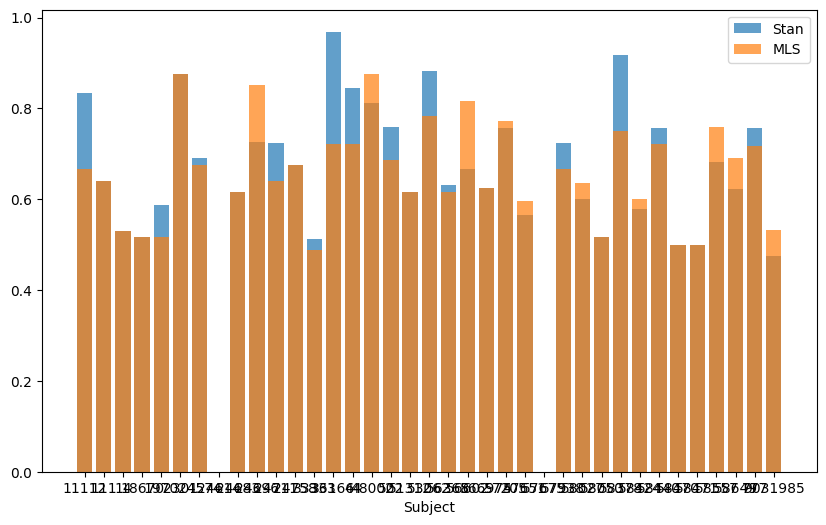

In [15]:
plt.figure(figsize=(10, 6))
plt.bar(auc_results.index, auc_results['roc_auc_stan'], label='Stan', alpha=0.7)
plt.bar(auc_results.index, auc_results['roc_auc_MLS'], label='MLS', alpha=0.7)
plt.xlabel('Subject')   
plt.legend()